# Over-Sampling

Oversampling adalah teknik yang digunakan untuk menangani ketidakseimbangan kelas (class imbalance) dalam dataset. Ketika salah satu kelas memiliki jumlah sampel jauh lebih sedikit dibanding kelas lain, model cenderung bias terhadap kelas mayoritas.

### Model Machine Learning

**Naive Bayes**
- Algoritma probabilistik berbasis **Teorema Bayes**.  
- Asumsi: fitur saling independen.  
- Cepat, sederhana, cocok untuk data teks.  
- Kurang akurat jika fitur saling bergantung.  

---

**Random Forest**
- **Ensemble** dari banyak Decision Tree.  
- Menggunakan **bootstrap sampling** + pemilihan fitur acak.  
- Akurat, tahan *overfitting*, stabil.  
- Lebih lambat, sulit diinterpretasi.  

---

**Bagging Classifier**
- **Bagging Classifier** adalah algoritma *ensemble learning* berbasis metode **Bagging (Bootstrap Aggregating)** untuk klasifikasi.  
Prinsipnya: melatih beberapa model (biasanya Decision Tree) pada data subset acak, lalu hasil prediksi digabung dengan voting mayoritas. 
- Melatih beberapa model pada subset data berbeda.  
- Mengurangi *overfitting*, lebih stabil.  
- Butuh komputasi lebih banyak.  


### Import Library

In [5]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import mysql.connector
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import LabelEncoder


### Pemanggilan data ecoli dari database Aiven


In [2]:
import pandas as pd
import mysql.connector
from dotenv import load_dotenv
import os

# arahkan ke file .env yang benar
load_dotenv(dotenv_path="/workspaces/PSD1/Tugas/.env")

def get_env(name: str) -> str:
    value = os.getenv(name)
    if not value:
        raise ValueError(f"Environment variable {name} tidak ditemukan di .env")
    return value

# Ambil variabel dari .env
host = get_env("DB_HOST")
port = int(get_env("DB_PORT"))
user = get_env("DB_USER")
password = get_env("DB_PASSWORD")
database = get_env("DB_NAME")

# Koneksi ke database
conn = mysql.connector.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database
)

query = "SELECT * FROM ecoli"
df = pd.read_sql(query, conn)
conn.close()

print("Data awal:")
print(df.head())


Data awal:
  sequence_name   mcg   gvh   lip  chg   aac  alm1  alm2 class
0     AAS_ECOLI  0.44  0.52  0.48  0.5  0.43  0.47  0.54    im
1     AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35    cp
2    ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44    cp
3    ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46    cp
4    ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36    cp


/tmp/ipykernel_5788/2402679444.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


### Eksplorasi Awal & Distribusi Kelas

In [7]:
print("Distribusi kelas asli:", Counter(df["class"]))


Distribusi kelas asli: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})


### Persiapan Data

In [8]:
df_features = df.drop(columns=["sequence_name", "class"])
y = df["class"]

Shape X: (336, 7)
Shape y: (336,)


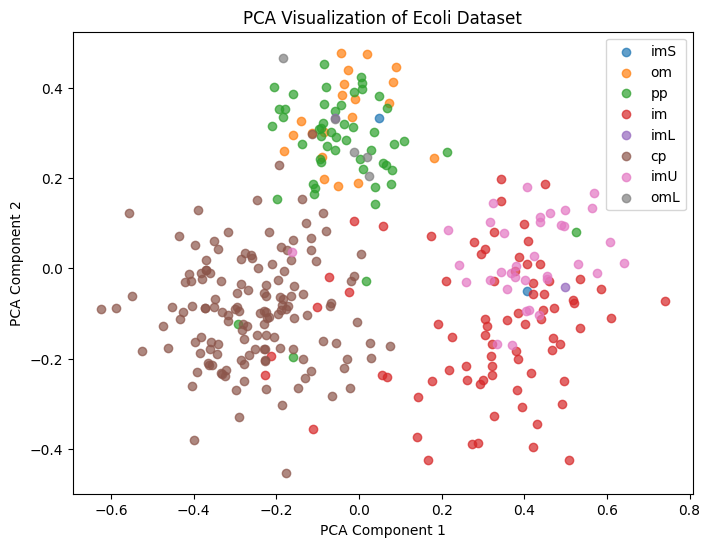

In [9]:
# X = fitur numerik, y = label
X = df_features.values
y = df["class"].values

print("Shape X:", X.shape)
print("Shape y:", y.shape)

# PCA ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot hasil PCA
plt.figure(figsize=(8,6))
for label in set(y):
    plt.scatter(
        X_pca[y == label, 0],
        X_pca[y == label, 1],
        label=label,
        alpha=0.7
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Ecoli Dataset")
plt.legend()
plt.show()

## 1. **Eksperimen 1 – Data Belum Diseimbangkan**

### **Naive Bayes – Data Belum Diseimbangkan**

Pada tahap ini, kita menggunakan **Naive Bayes (GaussianNB)** untuk melakukan klasifikasi pada dataset asli *tanpa penyeimbangan kelas*.  
Langkah-langkah:
1. Pisahkan data menjadi training dan testing (80:20, stratified).
2. Latih model Naive Bayes pada data training.
3. Evaluasi model dengan data testing menggunakan akurasi, classification report, dan confusion matrix.


In [10]:
# Pisahkan data (belum seimbang)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inisialisasi model Naive Bayes
nb = GaussianNB()

# Latih model
nb.fit(X_train, y_train)

# Prediksi data uji
y_pred = nb.predict(X_test)

# Evaluasi hasil
print("🔹 Akurasi Naive Bayes (data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Naive Bayes (data asli): 0.8529411764705882

Classification Report:
               precision    recall  f1-score   support

          cp       0.97      1.00      0.98        29
          im       0.85      0.69      0.76        16
         imU       0.67      0.57      0.62         7
          om       1.00      0.50      0.67         4
         omL       0.50      1.00      0.67         1
          pp       0.73      1.00      0.85        11

    accuracy                           0.85        68
   macro avg       0.79      0.79      0.76        68
weighted avg       0.86      0.85      0.85        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 1 11  2  0  0  2]
 [ 0  2  4  0  0  1]
 [ 0  0  0  2  1  1]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0 11]]


### **Random Forest – Data Belum Diseimbangkan**

Pada tahap ini, kita menggunakan **Random Forest Classifier** untuk melakukan klasifikasi pada dataset asli *tanpa penyeimbangan kelas*.  
Langkah-langkah:
1. Pisahkan data menjadi training dan testing (80:20, stratified).
2. Latih model Random Forest pada data training.
3. Evaluasi model dengan data testing menggunakan akurasi, classification report, dan confusion matrix.


In [11]:
# Pisahkan data (belum seimbang)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inisialisasi Random Forest
rf = RandomForestClassifier(
    n_estimators=100,      # jumlah pohon
    random_state=42,
    class_weight=None      # karena data belum seimbang, kita biarkan default
)

# Latih model
rf.fit(X_train, y_train)

# Prediksi data uji
y_pred = rf.predict(X_test)

# Evaluasi hasil
print("🔹 Akurasi Random Forest (data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Random Forest (data asli): 0.8970588235294118

Classification Report:
               precision    recall  f1-score   support

          cp       0.97      1.00      0.98        29
          im       0.79      0.94      0.86        16
         imU       0.75      0.43      0.55         7
          om       1.00      0.75      0.86         4
         omL       1.00      1.00      1.00         1
          pp       0.91      0.91      0.91        11

    accuracy                           0.90        68
   macro avg       0.90      0.84      0.86        68
weighted avg       0.90      0.90      0.89        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 0 15  1  0  0  0]
 [ 0  4  3  0  0  0]
 [ 0  0  0  3  0  1]
 [ 0  0  0  0  1  0]
 [ 1  0  0  0  0 10]]


### **Bagging Classifier – Data Belum Diseimbangkan**

Pada tahap ini, kita menggunakan **Bagging Classifier** untuk melakukan klasifikasi pada dataset asli *tanpa penyeimbangan kelas*.  
Bagging akan dilatih dengan dua skenario:
1. Menggunakan **Naive Bayes** sebagai base estimator.
2. Menggunakan **Decision Tree** sebagai base estimator (default yang paling sering digunakan).  

Langkah-langkah:
1. Pisahkan data menjadi training dan testing (80:20, stratified).
2. Latih model Bagging dengan base estimator yang dipilih.
3. Evaluasi model menggunakan akurasi, classification report, dan confusion matrix.


#### Bagging dengan Naive Bayes

In [12]:
# Base estimator = Naive Bayes
bag_nb = BaggingClassifier(
    estimator=GaussianNB(),
    n_estimators=100,
    random_state=42
)

# Latih model
bag_nb.fit(X_train, y_train)

# Prediksi
y_pred = bag_nb.predict(X_test)

# Evaluasi
print("🔹 Akurasi Bagging (base Naive Bayes, data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (base Naive Bayes, data asli): 0.8382352941176471

Classification Report:
               precision    recall  f1-score   support

          cp       0.97      1.00      0.98        29
          im       0.73      0.69      0.71        16
         imU       0.60      0.43      0.50         7
          om       1.00      0.50      0.67         4
         omL       0.50      1.00      0.67         1
          pp       0.79      1.00      0.88        11

    accuracy                           0.84        68
   macro avg       0.76      0.77      0.73        68
weighted avg       0.84      0.84      0.83        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 1 11  2  0  0  2]
 [ 0  4  3  0  0  0]
 [ 0  0  0  2  1  1]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0 11]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(se

#### Bagging dengan Decision Tree

In [13]:
# Base estimator = Decision Tree
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

# Latih model
bag_dt.fit(X_train, y_train)

# Prediksi
y_pred = bag_dt.predict(X_test)

# Evaluasi
print("🔹 Akurasi Bagging (base Decision Tree, data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (base Decision Tree, data asli): 0.8823529411764706

Classification Report:
               precision    recall  f1-score   support

          cp       0.97      1.00      0.98        29
          im       0.79      0.94      0.86        16
         imU       0.60      0.43      0.50         7
          om       1.00      0.50      0.67         4
         omL       1.00      1.00      1.00         1
          pp       0.91      0.91      0.91        11

    accuracy                           0.88        68
   macro avg       0.88      0.80      0.82        68
weighted avg       0.88      0.88      0.87        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 0 15  1  0  0  0]
 [ 0  4  3  0  0  0]
 [ 0  0  1  2  0  1]
 [ 0  0  0  0  1  0]
 [ 1  0  0  0  0 10]]


## **2. Eksperimen 2 – Data Seimbang dengan SMOTE**

Pada eksperimen kedua, dataset yang sebelumnya tidak seimbang akan diseimbangkan menggunakan **SMOTE (Synthetic Minority Oversampling Technique)**.  
SMOTE bekerja dengan cara membuat data sintetis baru untuk kelas minoritas berdasarkan interpolasi antar tetangga terdekat.  

Langkah-langkah:
1. Terapkan SMOTE pada data asli.
2. Periksa kembali distribusi kelas setelah SMOTE.
3. Simpan data hasil balancing untuk digunakan pada klasifikasi berikutnya (Naive Bayes, Random Forest, Bagging).


In [14]:
# Terapkan SMOTE
smote = SMOTE(k_neighbors=1 ,random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

print("Distribusi sebelum SMOTE:", Counter(y))
print("Distribusi sesudah SMOTE:", Counter(y_sm))


Distribusi sebelum SMOTE: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})
Distribusi sesudah SMOTE: Counter({'im': 143, 'cp': 143, 'pp': 143, 'imU': 143, 'imS': 143, 'om': 143, 'imL': 143, 'omL': 143})


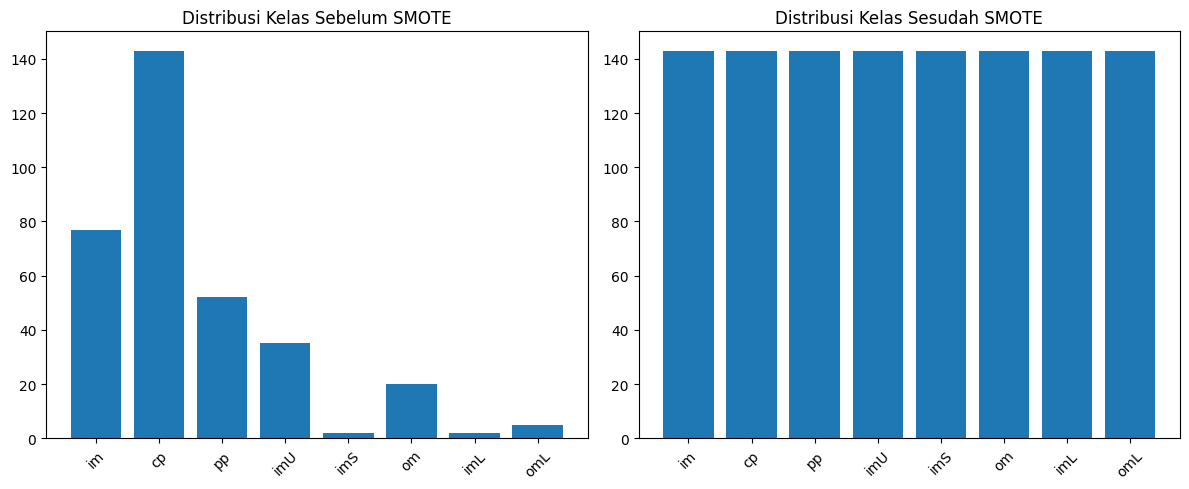

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Sebelum SMOTE
axes[0].bar(Counter(y).keys(), Counter(y).values())
axes[0].set_title("Distribusi Kelas Sebelum SMOTE")
axes[0].tick_params(axis='x', rotation=45)

# Sesudah SMOTE
axes[1].bar(Counter(y_sm).keys(), Counter(y_sm).values())
axes[1].set_title("Distribusi Kelas Sesudah SMOTE")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()




#### PCA dengan SMOTE

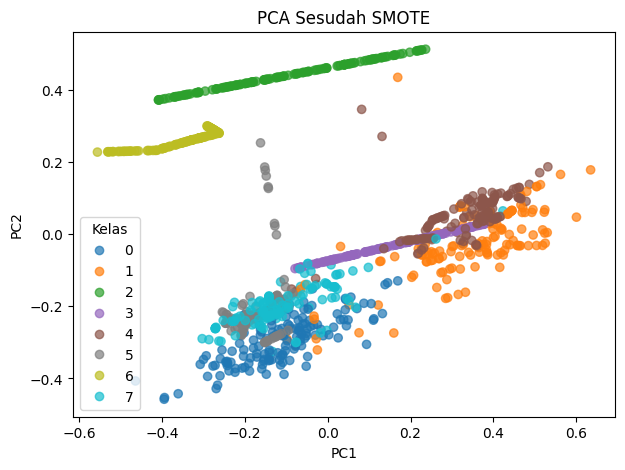

In [16]:
from sklearn.preprocessing import LabelEncoder

# Encode label kategori jadi angka
le = LabelEncoder()
y_sm_encoded = le.fit_transform(y_sm)

# Lakukan PCA ke 2 dimensi
pca = PCA(n_components=2, random_state=42)
X_sm_pca = pca.fit_transform(X_sm)

# Plot hasil PCA sesudah SMOTE
plt.figure(figsize=(7,5))
scatter = plt.scatter(
    X_sm_pca[:, 0],
    X_sm_pca[:, 1],
    c=y_sm_encoded, cmap="tab10", alpha=0.7
)

# Buat legenda otomatis
plt.legend(
    *scatter.legend_elements(),
    title="Kelas"
)

plt.title("PCA Sesudah SMOTE")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


### **Naive Bayes – Data Seimbang (SMOTE)**

Setelah dataset diseimbangkan menggunakan **SMOTE**, model **Naive Bayes (GaussianNB)** digunakan kembali untuk klasifikasi.  
Langkah-langkah:
1. Bagi dataset hasil SMOTE menjadi data latih (train) dan data uji (test).
2. Latih model Naive Bayes pada data latih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


In [17]:
# Split data SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm
)

# Inisialisasi Naive Bayes dengan smoothing
nb = GaussianNB(var_smoothing=1e-8)

# Latih model
nb.fit(X_train, y_train)

# Prediksi data uji
y_pred = nb.predict(X_test)

# Evaluasi hasil
print("🔹 Akurasi Naive Bayes (SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Naive Bayes (SMOTE): 0.8078602620087336

Classification Report:
               precision    recall  f1-score   support

          cp       0.90      0.96      0.93        28
          im       0.49      0.93      0.64        28
         imL       0.97      1.00      0.98        29
         imS       1.00      1.00      1.00        29
         imU       1.00      0.03      0.07        29
          om       0.89      0.61      0.72        28
         omL       1.00      1.00      1.00        29
          pp       0.71      0.93      0.81        29

    accuracy                           0.81       229
   macro avg       0.87      0.81      0.77       229
weighted avg       0.87      0.81      0.77       229


Confusion Matrix:
 [[27  1  0  0  0  0  0  0]
 [ 1 26  1  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 0 26  0  0  1  2  0  0]
 [ 0  0  0  0  0 17  0 11]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  0  0 27]]


### **Random Forest – Data Seimbang (SMOTE)**

Setelah dataset diseimbangkan menggunakan **SMOTE**, model **Random Forest Classifier** digunakan untuk klasifikasi.  
Langkah-langkah:
1. Bagi dataset hasil SMOTE menjadi data latih (train) dan data uji (test).
2. Latih model Random Forest pada data latih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


In [18]:
# Split data SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm
)

# Inisialisasi Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Latih model
rf.fit(X_train, y_train)

# Prediksi data uji
y_pred = rf.predict(X_test)

# Evaluasi hasil
print("🔹 Akurasi Random Forest (SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Random Forest (SMOTE): 0.9737991266375546

Classification Report:
               precision    recall  f1-score   support

          cp       0.90      1.00      0.95        28
          im       0.93      0.93      0.93        28
         imL       0.97      1.00      0.98        29
         imS       1.00      1.00      1.00        29
         imU       1.00      0.93      0.96        29
          om       1.00      1.00      1.00        28
         omL       1.00      1.00      1.00        29
          pp       1.00      0.93      0.96        29

    accuracy                           0.97       229
   macro avg       0.97      0.97      0.97       229
weighted avg       0.98      0.97      0.97       229


Confusion Matrix:
 [[28  0  0  0  0  0  0  0]
 [ 1 26  1  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 0  2  0  0 27  0  0  0]
 [ 0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  0  0 27]]


### **Bagging Classifier – Data Seimbang (SMOTE)**

Setelah dataset diseimbangkan menggunakan **SMOTE**, model **Bagging Classifier** digunakan untuk klasifikasi.  
Dua skenario diuji:
1. Bagging dengan **Naive Bayes** sebagai base estimator.
2. Bagging dengan **Decision Tree** sebagai base estimator.  

Langkah-langkah:
1. Bagi dataset hasil SMOTE menjadi data latih (train) dan data uji (test).
2. Latih model Bagging dengan estimator terpilih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


#### Bagging dengan Naive Bayes

In [19]:
# Bagging dengan Naive Bayes
bag_nb = BaggingClassifier(
    estimator=GaussianNB(var_smoothing=1e-8),
    n_estimators=100,
    random_state=42
)

bag_nb.fit(X_train, y_train)
y_pred = bag_nb.predict(X_test)

print("🔹 Akurasi Bagging (Naive Bayes, SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (Naive Bayes, SMOTE): 0.8034934497816594

Classification Report:
               precision    recall  f1-score   support

          cp       0.90      0.96      0.93        28
          im       0.47      0.93      0.63        28
         imL       0.97      1.00      0.98        29
         imS       1.00      0.93      0.96        29
         imU       1.00      0.03      0.07        29
          om       0.90      0.64      0.75        28
         omL       1.00      1.00      1.00        29
          pp       0.73      0.93      0.82        29

    accuracy                           0.80       229
   macro avg       0.87      0.80      0.77       229
weighted avg       0.87      0.80      0.77       229


Confusion Matrix:
 [[27  1  0  0  0  0  0  0]
 [ 1 26  1  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  0]
 [ 0  2  0 27  0  0  0  0]
 [ 0 26  0  0  1  2  0  0]
 [ 0  0  0  0  0 18  0 10]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  0  0 27]]


#### Bagging dengan Decision Tree

In [20]:
# Bagging dengan Decision Tree
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

bag_dt.fit(X_train, y_train)
y_pred = bag_dt.predict(X_test)

print("🔹 Akurasi Bagging (Decision Tree, SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (Decision Tree, SMOTE): 0.9650655021834061

Classification Report:
               precision    recall  f1-score   support

          cp       0.90      0.96      0.93        28
          im       0.93      0.93      0.93        28
         imL       0.94      1.00      0.97        29
         imS       1.00      1.00      1.00        29
         imU       1.00      0.93      0.96        29
          om       0.97      1.00      0.98        28
         omL       1.00      1.00      1.00        29
          pp       1.00      0.90      0.95        29

    accuracy                           0.97       229
   macro avg       0.97      0.97      0.96       229
weighted avg       0.97      0.97      0.97       229


Confusion Matrix:
 [[27  1  0  0  0  0  0  0]
 [ 1 26  1  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 0  1  1  0 27  0  0  0]
 [ 0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  1  0 26]]


## **3. Eksperimen 3 – ADASYN**

Pada eksperimen ini digunakan teknik **ADASYN (Adaptive Synthetic Sampling)** untuk menyeimbangkan data.  
Langkah-langkah:
1. Pisahkan fitur (X) dan label (y).
2. Terapkan ADASYN dengan variasi parameter `n_neighbors` sesuai distribusi kelas.
3. Simpan hasil akhir dataset seimbang untuk digunakan dalam klasifikasi (Naive Bayes, Random Forest, dan Bagging).
4. Tampilkan distribusi kelas sebelum dan sesudah ADASYN.


In [21]:
naive_bayes = df
X = naive_bayes.drop(columns=["class", "sequence_name"])  # fitur numerik
y = naive_bayes["class"]

print("\nDistribusi kelas awal:")
print(sorted(Counter(y).items()))

class_counts = [count for _, count in Counter(y).items()]
temp = sorted(class_counts)

nt, ns = X, y  # salin awal
print(f"\nSorted counts untuk iterasi: {temp}")

for i in range(0, min(7, len(temp))):
    n = max(1, temp[i] - 1)  # n_neighbors tidak boleh < 1
    # print(f"\nIterasi {i+1}: menggunakan k_neighbors={n}")

    try:
        sampler = ADASYN(n_neighbors=n, sampling_strategy='minority', random_state=42)
        nt, ns = sampler.fit_resample(nt, ns)
        # print(f"Hasil iterasi {i+1}: {sorted(Counter(ns).items())}")
    except Exception as e:
        print(f"Error pada iterasi {i+1}: {e}")
        break

# ==========================
# 4. Hasil akhir
# ==========================
print(f"\nDistribusi kelas setelah ADASYN:")
print(f"{sorted(Counter(ns).items())}")

print(f"\nTotal samples sebelum: {len(y)}")
print(f"Total samples setelah: {len(ns)}")
print(f"Data yang ditambahkan: {len(ns) - len(y)}")



Distribusi kelas awal:
[('cp', 143), ('im', 77), ('imL', 2), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Sorted counts untuk iterasi: [2, 2, 5, 20, 35, 52, 77, 143]

Distribusi kelas setelah ADASYN:
[('cp', 143), ('im', 154), ('imL', 142), ('imS', 142), ('imU', 146), ('om', 143), ('omL', 143), ('pp', 146)]

Total samples sebelum: 336
Total samples setelah: 1159
Data yang ditambahkan: 823


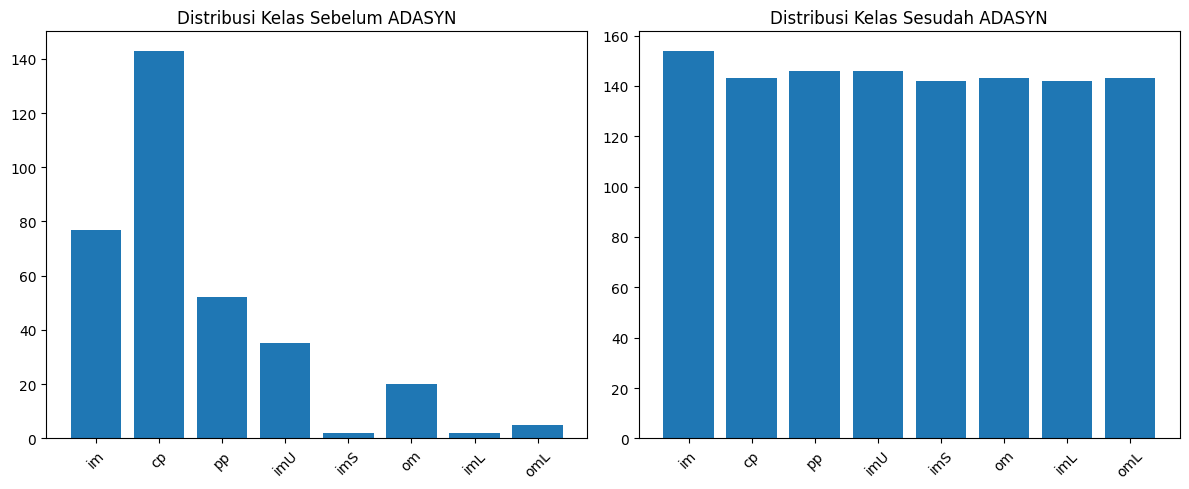

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Sebelum ADASYN
axes[0].bar(Counter(y).keys(), Counter(y).values())
axes[0].set_title("Distribusi Kelas Sebelum ADASYN")
axes[0].tick_params(axis='x', rotation=45)

# Sesudah ADASYN
axes[1].bar(Counter(ns).keys(), Counter(ns).values())
axes[1].set_title("Distribusi Kelas Sesudah ADASYN")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### PCA sesudah ADASYN

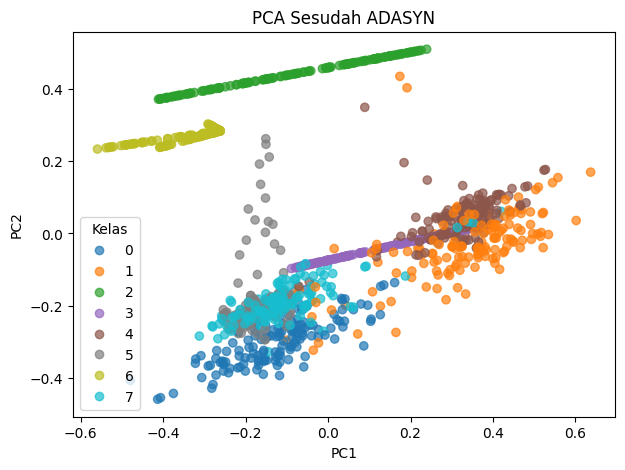

In [23]:
# Encode label kategori (supaya bisa diberi warna)
le = LabelEncoder()
ns_encoded = le.fit_transform(ns)

# PCA ke 2 dimensi (fitur hasil ADASYN = nt)
pca = PCA(n_components=2, random_state=42)
X_ns_pca = pca.fit_transform(nt)

# Scatter plot
plt.figure(figsize=(7,5))
scatter = plt.scatter(
    X_ns_pca[:,0],
    X_ns_pca[:,1],
    c=ns_encoded, cmap="tab10", alpha=0.7
)

# Tambahkan legenda
plt.legend(*scatter.legend_elements(), title="Kelas")

plt.title("PCA Sesudah ADASYN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


### **Naive Bayes – Data Seimbang (ADASYN)**

Setelah dataset diseimbangkan menggunakan **ADASYN**, model **Naive Bayes (GaussianNB)** digunakan untuk klasifikasi.  
Langkah-langkah:
1. Bagi dataset hasil ADASYN menjadi data latih (train) dan data uji (test).
2. Latih model Naive Bayes pada data latih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


In [24]:
# Split data ADASYN
X_train, X_test, y_train, y_test = train_test_split(
    nt, ns, test_size=0.3, random_state=42, stratify=ns
)

# Inisialisasi Naive Bayes
nb = GaussianNB()

# Latih model
nb.fit(X_train, y_train)

# Prediksi
y_pred = nb.predict(X_test)

# Evaluasi
print("🔹 Akurasi Naive Bayes (ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Naive Bayes (ADASYN): 0.7931034482758621

Classification Report:
               precision    recall  f1-score   support

          cp       0.84      0.98      0.90        43
          im       0.50      0.91      0.65        46
         imL       0.98      1.00      0.99        43
         imS       1.00      0.98      0.99        42
         imU       1.00      0.02      0.04        44
          om       0.89      0.56      0.69        43
         omL       1.00      1.00      1.00        43
          pp       0.69      0.91      0.78        44

    accuracy                           0.79       348
   macro avg       0.86      0.79      0.76       348
weighted avg       0.86      0.79      0.75       348


Confusion Matrix:
 [[42  1  0  0  0  0  0  0]
 [ 2 42  1  0  0  1  0  0]
 [ 0  0 43  0  0  0  0  0]
 [ 0  1  0 41  0  0  0  0]
 [ 1 40  0  0  1  2  0  0]
 [ 1  0  0  0  0 24  0 18]
 [ 0  0  0  0  0  0 43  0]
 [ 4  0  0  0  0  0  0 40]]


### **Random Forest – Data Seimbang (ADASYN)**

Setelah dataset diseimbangkan menggunakan **ADASYN**, model **Random Forest** digunakan untuk klasifikasi.  
Langkah-langkah:
1. Bagi dataset hasil ADASYN menjadi data latih (train) dan data uji (test).
2. Latih model Random Forest pada data latih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


In [25]:
# Split data ADASYN (sudah sama seperti sebelumnya, jadi bisa pakai ulang)
X_train, X_test, y_train, y_test = train_test_split(
    nt, ns, test_size=0.2, random_state=42, stratify=ns
)

# Inisialisasi Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Latih model
rf.fit(X_train, y_train)

# Prediksi
y_pred = rf.predict(X_test)

# Evaluasi
print("🔹 Akurasi Random Forest (ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Random Forest (ADASYN): 0.9525862068965517

Classification Report:
               precision    recall  f1-score   support

          cp       0.88      1.00      0.94        29
          im       0.90      0.90      0.90        31
         imL       0.97      1.00      0.98        28
         imS       1.00      1.00      1.00        28
         imU       0.96      0.90      0.93        29
          om       0.97      0.97      0.97        29
         omL       1.00      1.00      1.00        29
          pp       0.96      0.86      0.91        29

    accuracy                           0.95       232
   macro avg       0.95      0.95      0.95       232
weighted avg       0.95      0.95      0.95       232


Confusion Matrix:
 [[29  0  0  0  0  0  0  0]
 [ 1 28  1  0  1  0  0  0]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0]
 [ 0  3  0  0 26  0  0  0]
 [ 0  0  0  0  0 28  0  1]
 [ 0  0  0  0  0  0 29  0]
 [ 3  0  0  0  0  1  0 25]]


### **Bagging Classifier – Data Seimbang (ADASYN)**

Setelah dataset diseimbangkan menggunakan **ADASYN**, model **Bagging Classifier** digunakan untuk klasifikasi.  
Dua skenario diuji:
1. Bagging dengan **Naive Bayes** sebagai base estimator.
2. Bagging dengan **Decision Tree** sebagai base estimator.

Langkah-langkah:
1. Bagi dataset hasil ADASYN menjadi data latih (train) dan data uji (test).
2. Latih model Bagging pada data latih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


#### Bagging dengan Naive Bayes

In [26]:
# Bagging dengan Naive Bayes
bag_nb = BaggingClassifier(
    estimator=GaussianNB(),
    n_estimators=100,
    random_state=42
)

bag_nb.fit(X_train, y_train)
y_pred = bag_nb.predict(X_test)

print("🔹 Akurasi Bagging (Naive Bayes, ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (Naive Bayes, ADASYN): 0.7801724137931034

Classification Report:
               precision    recall  f1-score   support

          cp       0.85      1.00      0.92        29
          im       0.50      0.87      0.64        31
         imL       0.97      1.00      0.98        28
         imS       1.00      1.00      1.00        28
         imU       1.00      0.03      0.07        29
          om       0.87      0.45      0.59        29
         omL       1.00      1.00      1.00        29
          pp       0.62      0.90      0.73        29

    accuracy                           0.78       232
   macro avg       0.85      0.78      0.74       232
weighted avg       0.85      0.78      0.74       232


Confusion Matrix:
 [[29  0  0  0  0  0  0  0]
 [ 2 27  1  0  0  1  0  0]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0]
 [ 0 27  0  0  1  1  0  0]
 [ 0  0  0  0  0 13  0 16]
 [ 0  0  0  0  0  0 29  0]
 [ 3  0  0  0  0  0  0 26]]


#### Bagging dengan Decision Tree

In [27]:
# Bagging dengan Decision Tree
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

bag_dt.fit(X_train, y_train)
y_pred = bag_dt.predict(X_test)

print("🔹 Akurasi Bagging (Decision Tree, ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (Decision Tree, ADASYN): 0.9439655172413793

Classification Report:
               precision    recall  f1-score   support

          cp       0.88      1.00      0.94        29
          im       0.93      0.84      0.88        31
         imL       0.93      1.00      0.97        28
         imS       1.00      1.00      1.00        28
         imU       0.90      0.90      0.90        29
          om       0.97      0.97      0.97        29
         omL       1.00      1.00      1.00        29
          pp       0.96      0.86      0.91        29

    accuracy                           0.94       232
   macro avg       0.95      0.95      0.94       232
weighted avg       0.95      0.94      0.94       232


Confusion Matrix:
 [[29  0  0  0  0  0  0  0]
 [ 1 26  1  0  3  0  0  0]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0]
 [ 0  2  1  0 26  0  0  0]
 [ 0  0  0  0  0 28  0  1]
 [ 0  0  0  0  0  0 29  0]
 [ 3  0  0  0  0  1  0 25]]


## Perbandingan Hasil Klasifikasi – Data Asli vs SMOTE vs ADASYN

Tabel berikut membandingkan performa model **Naive Bayes, Random Forest, dan Bagging** pada tiga kondisi data:
- **Asli (belum diseimbangkan)**
- **SMOTE (Synthetic Minority Oversampling Technique)**
- **ADASYN (Adaptive Synthetic Sampling)**

Metrik yang digunakan:
- **Accuracy**
- **Macro F1-score**


In [28]:
from sklearn.metrics import f1_score

# Reset results
results = []

def evaluate_model(name, model, X_tr, X_te, y_tr, y_te, dataset_label):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average="macro")
    results.append({
        "Model": name,
        "Dataset": dataset_label,
        "Accuracy": round(acc, 4),
        "Macro F1": round(f1, 4)
    })

# =============================
# 1. Data Asli
# =============================
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

evaluate_model("Naive Bayes", GaussianNB(), X_train0, X_test0, y_train0, y_test0, "Asli")
evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), X_train0, X_test0, y_train0, y_test0, "Asli")
evaluate_model("Bagging (NB)", BaggingClassifier(estimator=GaussianNB(), n_estimators=100, random_state=42), X_train0, X_test0, y_train0, y_test0, "Asli")
evaluate_model("Bagging (DT)", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42), X_train0, X_test0, y_train0, y_test0, "Asli")

# =============================
# 2. Data SMOTE
# =============================
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_sm, y_sm, test_size=0.2, stratify=y_sm, random_state=42)

evaluate_model("Naive Bayes", GaussianNB(), X_train1, X_test1, y_train1, y_test1, "SMOTE")
evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), X_train1, X_test1, y_train1, y_test1, "SMOTE")
evaluate_model("Bagging (NB)", BaggingClassifier(estimator=GaussianNB(), n_estimators=100, random_state=42), X_train1, X_test1, y_train1, y_test1, "SMOTE")
evaluate_model("Bagging (DT)", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42), X_train1, X_test1, y_train1, y_test1, "SMOTE")

# =============================
# 3. Data ADASYN
# =============================
X_train2, X_test2, y_train2, y_test2 = train_test_split(nt, ns, test_size=0.2, stratify=ns, random_state=42)

evaluate_model("Naive Bayes", GaussianNB(), X_train2, X_test2, y_train2, y_test2, "ADASYN")
evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), X_train2, X_test2, y_train2, y_test2, "ADASYN")
evaluate_model("Bagging (NB)", BaggingClassifier(estimator=GaussianNB(), n_estimators=100, random_state=42), X_train2, X_test2, y_train2, y_test2, "ADASYN")
evaluate_model("Bagging (DT)", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42), X_train2, X_test2, y_train2, y_test2, "ADASYN")

# =============================
# Hasil ke DataFrame
# =============================
df_results = pd.DataFrame(results)
df_results_pivot = df_results.pivot(index="Model", columns="Dataset", values=["Accuracy", "Macro F1"])
df_results_pivot


/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(se

Accuracy                 Macro F1                
Dataset         ADASYN    Asli   SMOTE   ADASYN    Asli   SMOTE
Model                                                          
Bagging (DT)    0.9440  0.8824  0.9651   0.9442  0.8193  0.9648
Bagging (NB)    0.7802  0.8382  0.7817   0.7410  0.7343  0.7421
Naive Bayes     0.7845  0.8529  0.7904   0.7443  0.7561  0.7485
Random Forest   0.9526  0.8971  0.9738   0.9530  0.8586  0.9737